### Project 3: Plausible Utopia 

### Classification Modeling on Subreddits to Classify Futurists vs. Scientists

### Notebook 2 of 3: Modeling

#### Libary imports

In [66]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import missingno as msno

from sklearn.linear_model import LinearRegression, LassoCV, RidgeCV, LogisticRegression
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.preprocessing import StandardScaler, PolynomialFeatures
from sklearn.neighbors import KNeighborsClassifier
from sklearn.pipeline import Pipeline
from sklearn import metrics
import statsmodels.api as sm
from sklearn.metrics import confusion_matrix, plot_confusion_matrix, classification_report, accuracy_score, roc_auc_score
from sklearn.naive_bayes import MultinomialNB
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer

     
from nltk.tokenize import sent_tokenize, word_tokenize, RegexpTokenizer
from nltk.stem import WordNetLemmatizer
from nltk.stem.porter import PorterStemmer
from nltk.corpus import stopwords
from nltk.sentiment.vader import SentimentIntensityAnalyzer
import re

import warnings; warnings.simplefilter('ignore')
##this will hide deprecation/future warnings

from IPython.display import Markdown, display
pd.set_option('display.max_row', 200) # Set ipython's max row display
pd.set_option('display.max_columns', 85) # Set iPython's max column count
pd.set_option('display.max_colwidth', 1_000) # Set iPython's max column width

# pseudo-markdown in code cells
def printmd(string):
    display(Markdown(string))
# ref: https://discuss.analyticsvidhya.com/t/how-to-make-a-text-bold-within-print-statement-in-ipython-notebook/14552/2

In [67]:
# Read in the cleaned data
subred = pd.read_csv('../data/cleaned_data/cleaned_df.csv')

# Check its shape
display(subred.shape)

# Preview
subred.head()

(1800, 2)

,subreddit,title
0,futurology,what would the point be to do anyth if ai could just do it all for us
1,futurology,elcc explain the critic renew energi concept you’v never heard of now we live in a day and age where some part of the countri gener more than 30 of their electr with variabl renew and that number will fast approach 100 in the decad to come
2,futurology,there a 5050 chanc were live in a simul and here how to find out the probabl will increas as we develop technolog enabl the creation of a simul contain consciou be
3,futurology,eight nation sign nasa artemi accord pledg peac on the moon it a reaffirm of the 1967 outer space treati
4,futurology,merced benz avtr in action


#### Set the features

In [68]:
# Set feature matrix and target variable

X = subred['title']
y = subred['subreddit']

read the following from ISLR:

5.2 - The Bootstrap. (You'll want to know the bootstrap well as it will be embedded in methods we'll discuss next week.)
Chapter 8 - Tree Based Methods. (We'll learn about classification and regression trees, random forests, bagging and boosting next week.)
9.1-9.5 (Support Vector Machines and related methods)

### Identify an optimal model with a pipeline and GridSearch

### Train-test split

 **Ref: 5.05 lesson**
 
 Features can be completely different in train/test
 
**IMPORTANT** Instead of splitting we can use entire dataset combined with cross-validation
 
 Depending on how big dataset is, significant words in train set will probably appear in test set

In [69]:
X_train, X_test, y_train, y_test = train_test_split(X,
                                                    y,
                                                    test_size = 0.33,
                                                    stratify = y,
                                                    random_state = 42)

display(X_train.shape)
display(y_train.shape)

display(X_test.shape)
display(y_test.shape)

(1206,)

(1206,)

(594,)

(594,)

### Baseline accuracy

**51.7% is the baseline accuracy percentage we compare with the model's accuracy.**

**If the model does better than the baseline, then it is better than null model (predicting the majority / plurality class).**

In [70]:
display(y.value_counts(normalize=True))

display(y_train.value_counts(normalize=True))

y_test.value_counts(normalize=True)

science       0.517222
futurology    0.482778
Name: subreddit, dtype: float64

science       0.517413
futurology    0.482587
Name: subreddit, dtype: float64

science       0.516835
futurology    0.483165
Name: subreddit, dtype: float64

## Cutoff point 

### Build pipelines

### Pipeline 1

**CountVectorizer (transformer)**:



**Multinomial Naive Bayes (estimator)**:

* Fast modeling algorithm
* Variables are positive integers
* Assumes all variables are independent (which is not realistic in NLP, but this assumption is accepted anyway)

In [58]:
# Let's set a pipeline up with two stages:
# 1. CountVectorizer (transformer)
# 2. Multinomial Naive Bayes (estimator)

pipe_cvec_nb = Pipeline([
    ('cvec', CountVectorizer()),
    ('nb', MultinomialNB())    # Naive Bayes
])


# Search over the following values of hyperparameters:
# Maximum number of features fit
# Minimum number of documents needed to include token
# Maximum number of documents needed to include token
# Check (individual tokens) and also check (individual tokens and 2-grams).

pipe_cvec_nb_params = {
    'cvec__max_features': [1_000, 2_000, 3_000, 4_000, 5_000],
    'cvec__min_df': [1, 2],
    'cvec__max_df': [.98, .99],
    'cvec__ngram_range': [(1,1), (1,2)]
}

# Instantiate GridSearchCV.

gs_cvec_nb = GridSearchCV(pipe_cvec_nb, # what object are we optimizing?
                  param_grid = pipe_cvec_nb_params, # what parameters values are we searching?
                  cv=5)      # 5-fold cross-validation.

In [59]:
# Fit GridSearch to data.
gs_cvec_nb.fit(X_train, y_train)

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('cvec', CountVectorizer()),
                                       ('nb', MultinomialNB())]),
             param_grid={'cvec__max_df': [0.98, 0.99],
                         'cvec__max_features': [1000, 2000, 3000, 4000, 5000],
                         'cvec__min_df': [1, 2],
                         'cvec__ngram_range': [(1, 1), (1, 2)]})

#### Evaluate the model

In [63]:
printmd('**Grid searched:**')
display(gs_cvec_nb.param_grid)
printmd(f'**Best accuracy score**: {round(gs_cvec_nb.best_score_, 4)}')
printmd('**Best estimator / parameters:**')
display(gs_cvec_nb.best_estimator_)
display(gs_cvec_nb.best_params_)

pd.DataFrame(gs_cvec_nb.cv_results_).sort_values('rank_test_score').head()

**Grid searched:**

{'cvec__max_features': [1000, 2000, 3000, 4000, 5000],
 'cvec__min_df': [1, 2],
 'cvec__max_df': [0.98, 0.99],
 'cvec__ngram_range': [(1, 1), (1, 2)]}

**Best accuracy score**: 0.8449

**Best estimator / parameters:**

Pipeline(steps=[('cvec',
                 CountVectorizer(max_df=0.98, max_features=4000,
                                 ngram_range=(1, 2))),
                ('nb', MultinomialNB())])

{'cvec__max_df': 0.98,
 'cvec__max_features': 4000,
 'cvec__min_df': 1,
 'cvec__ngram_range': (1, 2)}

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_cvec__max_df,param_cvec__max_features,param_cvec__min_df,param_cvec__ngram_range,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
33,0.059890,0.004141,0.011228,0.004603,0.99,4000,1,"(1, 2)","{'cvec__max_df': 0.99, 'cvec__max_features': 4000, 'cvec__min_df': 1, 'cvec__ngram_range': (1, 2)}",0.859504,0.838174,0.875519,0.804979,0.846473,0.844930,0.023631,1
13,0.127961,0.008736,0.018089,0.003119,0.98,4000,1,"(1, 2)","{'cvec__max_df': 0.98, 'cvec__max_features': 4000, 'cvec__min_df': 1, 'cvec__ngram_range': (1, 2)}",0.859504,0.838174,0.875519,0.804979,0.846473,0.844930,0.023631,1
28,0.024478,0.003177,0.003167,0.003207,0.99,3000,1,"(1, 1)","{'cvec__max_df': 0.99, 'cvec__max_features': 3000, 'cvec__min_df': 1, 'cvec__ngram_range': (1, 1)}",0.842975,0.846473,0.875519,0.788382,0.846473,0.839964,0.028350,3
8,0.049951,0.000637,0.010269,0.000127,0.98,3000,1,"(1, 1)","{'cvec__max_df': 0.98, 'cvec__max_features': 3000, 'cvec__min_df': 1, 'cvec__ngram_range': (1, 1)}",0.842975,0.846473,0.875519,0.788382,0.846473,0.839964,0.028350,3
32,0.021115,0.002558,0.005106,0.003001,0.99,4000,1,"(1, 1)","{'cvec__max_df': 0.99, 'cvec__max_features': 4000, 'cvec__min_df': 1, 'cvec__ngram_range': (1, 1)}",0.842975,0.854772,0.867220,0.788382,0.842324,0.839134,0.026960,5


#### Predictions

credit: NLP II: `CountVectorizer`, `TfidfVectorizer`, and Modeling lesson. _Authors: Dave Yerrington (SF), Justin Pounders (ATL), Riley Dallas (ATX), Matt Brems (DC), Noelle Brown (DEN)_

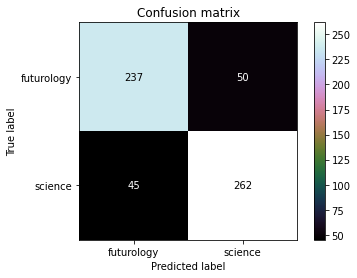

In [64]:
# Get predictions
preds = gs_cvec_nb.predict(X_test)

# Save confusion matrix values
tn, fp, fn, tp = confusion_matrix(y_test, preds).ravel()

# View confusion matrix

plot_confusion_matrix(gs_cvec_nb, X_test, y_test, cmap='cubehelix', values_format='d');
plt.title('Confusion matrix')

printmd('credit: NLP II: `CountVectorizer`, `TfidfVectorizer`, and Modeling lesson. _Authors: Dave Yerrington (SF), Justin Pounders (ATL), Riley Dallas (ATX), Matt Brems (DC), Noelle Brown (DEN)_')

In [65]:
# Calculate the accuracy

acc = (tp + tn) / (tp + fp + tn + fn)
print('Accuracy:', acc)

# Calculate the misclassification rate

misclass = (fp + fn) / (tp + fp + tn + fn)
print('Misclassification:', misclass)

# Calculate the sensitivity

sens = tp / (tp + fn)
print('Sensitivity:', sens)

# Calculate the precision

prec = tp / (tp + fp)
print('Precision:', prec)

# Calculate the specificity

spec = tn / (tn + fp)
print('Specificity:', spec)

def metrics(y_test, y_predict, pred_proba):
    print('Accuracy score %s ' % accuracy_score(y_test, y_predict), '\n')
    print('----------------------------------------------------------------')
    print(pd.DataFrame(confusion_matrix(y_test, y_predict), 
                            index=['Not Actual Disaster', 'Actual Disaster'], 
                            columns=['Predicted Not Actual Disaster', 'Predicted Disaster']), '\n')
    print('-----------------------------------------------------------------')
    print(classification_report(y_test, y_predict))
    print('-----------------------------------------------------------------')
    print('ROC_AUC SCORE %s ' %roc_auc_score(y_test, pred_proba))
    
# credit: Heather Robinson :-)

Accuracy: 0.8400673400673401
Misclassification: 0.15993265993265993
Sensitivity: 0.8534201954397395
Precision: 0.8397435897435898
Specificity: 0.8257839721254355


#### Update the scoreboard or not? These are artificially high scores

| Model # |     Model metrics     |  Score | Before preprocessing shape | train_test_split  | Value |   Pipeline  |        pipe_cvec_nb       | Pipe hyperparameters |                         Value set                         | GridsearchCV parameters | Value | GridsearchCV BEST parameters | Value  |
|:-------:|:---------------------:|:------:|:--------------------------:|:-----------------:|:-----:|:-----------:|:-------------------------:|:--------------------:|:---------------------------------------------------------:|:-----------------------:|:-----:|:----------------------------:|--------|
|    1    |       Best score      | 0.8389 |          (1800, 7)         |     test_size     |  0.33 | Transformer | 'cvec', CountVectorizer() |     max_features     | 'cvec__max_features': [1_000, 2_000, 3_000, 4_000, 5_000] | k-fold cross-validation |   5   | cvec__max_df                 | 0.98   |
|    1    | |  |                            |      stratify     |   y   |  Estimator  |   'nb', MultinomialNB()   |        min_df        |                   'cvec__min_df': [1, 2]                  |                         |       | cvec__max_features           | 4000   |
|    1    |   |  |                            |    random_state   |   42  |             |                           |        max_df        |                 'cvec__max_df': [.98, .99]                |                         |       | cvec__min_df                 | 1      |
|    1    |                       |        |                            |                   |       |             |                           |      ngram_range     |             'cvec__ngram_range': [(1,1), (1,2)            |                         |       | cvec__ngram_range            | (1, 2) |
|    1    |                       |        |                            |                   |       |             |                           |                      |                                                           |                         |       |                              |        |

### Pipeline 1 Part 2

**CountVectorizer (transformer)**:



**Multinomial Naive Bayes (estimator)**:

* Fast modeling algorithm
* Variables are positive integers
* Assumes all variables are independent (which is not realistic in NLP, but this assumption is accepted anyway)

In [71]:
# Let's set a pipeline up with two stages:
# 1. CountVectorizer (transformer)
# 2. Multinomial Naive Bayes (estimator)

pipe_cvec_nb = Pipeline([
    ('cvec', CountVectorizer()),
    ('nb', MultinomialNB())    # Naive Bayes
])


# Search over the following values of hyperparameters:
# Maximum number of features fit
# Minimum number of documents needed to include token
# Maximum number of documents needed to include token
# Check (individual tokens) and also check (individual tokens and 2-grams).

pipe_cvec_nb_params = {
    'cvec__max_features': [2_000, 4_000, 6_000],
    'cvec__min_df': [1, 2],
    'cvec__max_df': [.05, .1, .25, .4],
    'cvec__ngram_range': [(1, 1), (1, 2)]
}

# Instantiate GridSearchCV.

gs_cvec_nb = GridSearchCV(pipe_cvec_nb, # what object are we optimizing?
                  param_grid = pipe_cvec_nb_params, # what parameters values are we searching?
                  cv=5)      # 5-fold cross-validation.

In [72]:
# Fit GridSearch to data.
gs_cvec_nb.fit(X_train, y_train)

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('cvec', CountVectorizer()),
                                       ('nb', MultinomialNB())]),
             param_grid={'cvec__max_df': [0.05, 0.1, 0.25, 0.4],
                         'cvec__max_features': [2000, 4000, 6000],
                         'cvec__min_df': [1, 2],
                         'cvec__ngram_range': [(1, 1), (1, 2)]})

**Evaluate the model**

In [73]:
printmd('**Grid searched:**')
display(gs_cvec_nb.param_grid)
printmd(f'**Best score**: {round(gs_cvec_nb.best_score_, 4)}')
printmd('**Best estimator / parameters:**')
display(gs_cvec_nb.best_estimator_)
display(gs_cvec_nb.best_params_)

pd.DataFrame(gs_cvec_nb.cv_results_).sort_values('rank_test_score').head()

**Grid searched:**

{'cvec__max_features': [2000, 4000, 6000],
 'cvec__min_df': [1, 2],
 'cvec__max_df': [0.05, 0.1, 0.25, 0.4],
 'cvec__ngram_range': [(1, 1), (1, 2)]}

**Best score**: 0.8458

**Best estimator / parameters:**

Pipeline(steps=[('cvec',
                 CountVectorizer(max_df=0.4, max_features=6000,
                                 ngram_range=(1, 2))),
                ('nb', MultinomialNB())])

{'cvec__max_df': 0.4,
 'cvec__max_features': 6000,
 'cvec__min_df': 1,
 'cvec__ngram_range': (1, 2)}

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_cvec__max_df,param_cvec__max_features,param_cvec__min_df,param_cvec__ngram_range,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
45,0.133253,0.018857,0.021290,0.007331,0.4,6000,1,"(1, 2)","{'cvec__max_df': 0.4, 'cvec__max_features': 6000, 'cvec__min_df': 1, 'cvec__ngram_range': (1, 2)}",0.867769,0.834025,0.863071,0.809129,0.854772,0.845753,0.021656,1
41,0.057068,0.003061,0.007757,0.002968,0.4,4000,1,"(1, 2)","{'cvec__max_df': 0.4, 'cvec__max_features': 4000, 'cvec__min_df': 1, 'cvec__ngram_range': (1, 2)}",0.867769,0.834025,0.871369,0.796680,0.846473,0.843263,0.027041,2
33,0.083011,0.034189,0.012905,0.004512,0.25,6000,1,"(1, 2)","{'cvec__max_df': 0.25, 'cvec__max_features': 6000, 'cvec__min_df': 1, 'cvec__ngram_range': (1, 2)}",0.867769,0.825726,0.863071,0.804979,0.850622,0.842433,0.023735,3
40,0.023425,0.003357,0.004573,0.003183,0.4,4000,1,"(1, 1)","{'cvec__max_df': 0.4, 'cvec__max_features': 4000, 'cvec__min_df': 1, 'cvec__ngram_range': (1, 1)}",0.842975,0.846473,0.863071,0.800830,0.846473,0.839964,0.020781,4
28,0.023059,0.003006,0.004931,0.003755,0.25,4000,1,"(1, 1)","{'cvec__max_df': 0.25, 'cvec__max_features': 4000, 'cvec__min_df': 1, 'cvec__ngram_range': (1, 1)}",0.842975,0.842324,0.871369,0.800830,0.842324,0.839964,0.022530,4


### Pipeline 2

**CountVectorizer (transformer)**:

**TF-IDF (transformer)**:



**Logistic Regression (estimator)**:

* Relatively interpretable results

In [25]:
cvec = CountVectorizer(X_train, stop_words = 'english')
pd.DataFrame(cvec.fit_transform(X_train).to_dense(),
            columns = cvec.get_feature_names())

ValueError: The truth value of a Series is ambiguous. Use a.empty, a.bool(), a.item(), a.any() or a.all().

In [6]:
# Let's set up another pipeline
# 1. CountVectorizer (transformer)
# 2. TfidfVectorizer (transformer)
# 3. LogisticRegression (estimator)

pipe_log_reg_with_cvec_tfidf = Pipeline([
    ('cvec', CountVectorizer(lowercase = False)),
#     ('tvec', TfidfVectorizer(lowercase = False)),
    ('log_reg', LogisticRegression())
])

# Search over the following values of hyperparameters:
# Maximum number of features fit
# Minimum number of documents needed to include token
# Maximum number of documents needed to include token
# Check (individual tokens) and also check (individual tokens and 2-grams).

# *****************************************************************************************************************
# solver_list = ['liblinear', 'newton-cg', 'lbfgs', 'sag', 'saga']
# params = dict(solver=solver_list)
# log_reg = LogisticRegression(C=1, n_jobs=-1, random_state=34)
# clf = GridSearchCV(log_reg, params, cv=5)
# clf.fit(X_train, y_train)
# scores = clf.cv_results_['mean_test_score']

# for score, solver in zip(scores, solver_list):
#     print(f"  {solver} {score:.3f}" )

# ref: https://towardsdatascience.com/dont-sweat-the-solver-stuff-aea7cddc3451
# *****************************************************************************************************************

pipe_log_reg_with_cvec_tfidf_params = {
    'cvec__max_features': [1_000, 3_000, 5_000],
    'cvec__min_df': [1, 2],
    'cvec__max_df': [.98, .99],
    'cvec__ngram_range': [(1,1), (2,1)],
    'cvec__stop_words': [None, 'english'],
#     'tvec__max_features': [3_000, 5_000],
#     'tvec__stop_words': [None, 'english'],
#     'tvec__ngram_range': [(1,1), (1,2)],
    'log_reg__C': [.001, .01, .1, 1],
    'log_reg__penalty': ['l1', 'l2'],
    'log_reg__max_iter': [50, 75, 100],
    'log_reg__random_state': [42], 
    'log_reg__solver': ['liblinear', 'newton-cg', 'lbfgs', 'sag', 'saga']
}

# Instantiate GridSearchCV.

gs_log_reg_with_cvec_tfidf = GridSearchCV(pipe_log_reg_with_cvec_tfidf, # what object are we optimizing?
                  param_grid = pipe_log_reg_with_cvec_tfidf_params, # what parameters values are we searching?
                  cv = 5)                                           # 5-fold cross-validation.

In [8]:
# Fit GridSearch to data.
pipe_log_reg_with_cvec_tfidf.fit(X_train, y_train)

Pipeline(steps=[('cvec', CountVectorizer(lowercase=False)),
                ('log_reg', LogisticRegression())])

In [9]:
printmd('**Grid searched:**')
display(gs_log_reg_with_cvec_tfidf.param_grid)
printmd(f'**Best score**: {round(gs_log_reg_with_cvec_tfidf.best_score_, 4)}')
printmd('**Best estimator / parameters:**')
display(gs_log_reg_with_cvec_tfidf.best_estimator_)
display(gs_log_reg_with_cvec_tfidf.best_params_)

pd.DataFrame(gs_log_reg_with_cvec_tfidf.cv_results_).sort_values('rank_test_score').head()

**Grid searched:**

{'cvec__max_features': [1000, 3000, 5000],
 'cvec__min_df': [1, 2],
 'cvec__max_df': [0.98, 0.99],
 'cvec__ngram_range': [(1, 1), (2, 1)],
 'cvec__stop_words': [None, 'english'],
 'log_reg__C': [0.001, 0.01, 0.1, 1],
 'log_reg__penalty': ['l1', 'l2'],
 'log_reg__max_iter': [50, 75, 100],
 'log_reg__random_state': [42],
 'log_reg__solver': ['liblinear', 'newton-cg', 'lbfgs', 'sag', 'saga']}

AttributeError: 'GridSearchCV' object has no attribute 'best_score_'

### Pipeline 3

Tout un ensemble

https://scikit-learn.org/stable/modules/ensemble.html

**CountVectorizer (transformer)**:



**Random Forest * LogReg * MNBayes (estimator) **:

* 

### Pipeline 4


**TfidfVectorizer (transformer)**



**SVG (estimator)**


<br>

### Break the pipe